unified => unified2
- (1), (2), (3)에 추가사항 기입 했습니다 (wordcloud, nltk 저장, Tree그려보기)
- pos filter는 찾아보니 특별한 건 없습니다. 다만 https://github.com/konlpy/konlpy/blob/master/konlpy/tag/_twitter.py 의 클래스 구조를 보니 nouns를 따로 걸러내는 건 있는 거 같아요! 그래서 wordcloud를 그릴 때 이용했습니다!
- stop words같은 건 따로 dictionay나 list를 만들어서 if~로 걸러내는 게 좋을 듯 해요. 이부분은 더 수정할게요!

In [1]:
import pandas as pd
import numpy as np
import konlpy
from konlpy.tag import Twitter
import nltk
from gensim import models
import re
import requests
import pickle
import os

C:\Users\hyeon\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
os.getcwd()

'C:\\Users\\hyeon\\Dropbox\\LegalProject\\4. Classification'

In [3]:
with open('data_order.pkl', 'rb') as data:
    order = pickle.load(data)
with open('data_reason.pkl', 'rb') as data:
    reason = pickle.load(data)

In [4]:
print(order)

{147458: '상고를 모두 기각한다.', 147459: '상고를 기각한다.', 147461: '상고를 모두 기각한다.', 141996: '원심판결 중 피고인 최재훈차주현에 대한 부분을 각 파기한다. 피고인 최재훈을 징역 4년에피고인 차주현을 징역 3년 6월에 각 처한다. 원심판결 선고 전의 구금일수 102일씩을 피고인 최재훈차주현에 대한 위 각 형에 산입한다. 피고인 최재훈차주현에 대한 열람정보를 각 5년간 열람에 제공한다.피고인 최재훈차주현에 대한 공소사실 중 각 청소년의성보호에관한법률위반(청소년강간등)의 점에 대한 공소를 모두 기각한다.검사의 피고인 도승준에 대한 항소를 기각한다. ', 86745: 'None', 165222: '원심판결을 파기하고사건을 서울동부지방법원 합의부에 환송한다.', 73106: '원심판결을 파기한다.피고인을 징역 3년에 처한다.원심판결 선고전의 구금일수 중 110일을 위 본형에 산입한다.단 이 재판확정일로부터 5년간 위 형의 집행을 유예한다.', 147472: '원심판결을 파기하고사건을 춘천지방법원 본원 합의부로 환송한다.', 180246: '원심판결을 파기하고사건을 수원지방법원 합의부에 환송한다.', 65559: '피고인 이현태을 징역 2년피고인 김태촌를 징역 3년에 각 처한다.이 판결 선고 전의 구금일수 52일을 피고인 김태촌에 대한 위 형에 산입한다.피고인 이현태로부터 12 000 000원을 추징한다.이 사건 공소사실 중 피고인 이현태에 대한 2002. 5. 8.자 부정처사후수뢰의 점피고인 김태촌에 대한 2002. 5. 8.자 뇌물공여의 점은 각 무죄. ', 150031: '원심판결을 파기하고사건을 서울중앙지방법원 합의부에 환송한다.', 180249: '원심판결을 파기하고사건을 서울중앙지방법원 합의부에 환송한다.', 163871: '상고를 모두 기각한다.', 179708: '상고를 기각한다.', 114723: '상고를 기각한다.상고 이후의 구금일수 중 90일을 본형에 산입한다.', 114724: '상고를 기각한다.', 9

In [7]:
token = [t for d in reason.values() for t in d]
print(len(token))

text = nltk.Text(token, name="NMSC")
print(text.vocab().most_common(100))

3876201
[(('하다', 'Verb'), 437495), (('피고인', 'Noun'), 91884), (('있다', 'Adjective'), 85714), (('되다', 'Verb'), 65422), (('없다', 'Adjective'), 54637), (('원심', 'Noun'), 51397), (('사실', 'Noun'), 50447), (('이유', 'Noun'), 44449), (('판결', 'Noun'), 43875), (('사건', 'Noun'), 33076), (('상고', 'Noun'), 31733), (('같다', 'Adjective'), 31624), (('아니다', 'Adjective'), 29066), (('인정', 'Noun'), 28710), (('판단', 'Noun'), 24531), (('대한', 'Noun'), 23708), (('피해자', 'Noun'), 21987), (('행위', 'Noun'), 21451), (('대하다', 'Verb'), 21188), (('공소', 'Noun'), 19791), (('받다', 'Verb'), 19220), (('선고', 'Noun'), 18027), (('증거', 'Noun'), 17542), (('보다', 'Verb'), 16740), (('이르다', 'Verb'), 16333), (('진술', 'Noun'), 15856), (('위법', 'Noun'), 15079), (('되어다', 'Verb'), 15037), (('기록', 'Noun'), 14959), (('부분', 'Noun'), 14508), (('법리', 'Noun'), 13496), (('경우', 'Noun'), 13320), (('범죄', 'Noun'), 13063), (('주장', 'Noun'), 12449), (('않다', 'Verb'), 12149), (('또는', 'Adverb'), 12113), (('파다', 'Verb'), 11205), (('위반', 'Noun'), 10927), (('오해', 'Nou

### (1) Tree 구조 그려보기 (는 저희가 갖고 있는 데이터가  완전한 문장이 아니고  토픽 워드 모델링 하는 용이라 원하는 POS만 걸러낸 상태라 트리 구조 그리는 게 의미 없긴 하지만 그냥 해봤어요..)

In [ ]:
test_tag = token[1:10]
parser_ko = nltk.RegexpParser("NP: {<Adjective>*<Noun>*}")
chunks_ko = parser_ko.parse(test_tag)
chunks_ko.draw()


### (2) plot부분 (혹시 필요할지 몰라) 따로 저장하기. 폰트는 굴림 체를 다운 받아서 사용했어요

In [ ]:
from matplotlib import pylab, font_manager, rc

font_fname = "gulim.ttc"
font_name = font_manager.FontProperties(fname=font_fname).get_name()

rc("font",family = font_name)

pylab.show = lambda: pylab.savefig("most_word.png")
text.plot(50)

# 여기서부터 doc2vec

In [5]:
sentences =[]
for i, j in reason.items():
    words =[]
    for k, l in j:
        words.append(k)
    sentences.append(models.doc2vec.LabeledSentence(words=words, tags=["SENT_{}".format(i)]))
sentences[0]

LabeledSentence(words=['실효', '호로', '개정', '전의', '이하', '누구', '용도', '사용', '목적', '경력', '자료', '수사', '경력', '자료', '이하', '경력', '자료', '취득', '서다', '규정', '경력', '자료', '취득', '자르다', '처벌', '전과', '수사', '자료', '관리', '실효', '기준', '전과자', '정상', '사회', '복귀', '보장', '입법', '목적', '경력', '자료', '법령', '규정', '용도', '사용', '주체', '항의', '규정', '경력', '자료', '회보', '취득', '자로', '한정', '경력', '자료', '취득', '자가', '법령', '규정', '용도', '경력', '자료', '사용', '별도', '처벌', '종합', '경력', '자료', '취득', '수사', '자료', '관리', '사람', '직무', '수사', '자료', '경력', '조회', '사람', '직접', '취득', '한정', '법리', '비추다', '살펴보다', '채용', '종합', '규정', '용도', '사용', '목적', '정화', '휴대폰', '촬영', '출력', '고소', '경력', '조회', '영인본', '취득', '유죄', '정당', '거기', '법리', '오해', '논리', '경험', '법칙', '배하', '자유', '심증', '주의', '한계', '벗다', '형사소송법', '호에', '사형', '무기', '이상', '징역', '금고', '양형', '부당', '사유', '허용', '가볍다', '양정', '부당', '적법', '명예훼손죄', '공연', '성은', '특정', '다수', '인식', '상태', '의미', '하므다', '비록', '개별', '사람', '유포', '이로', '특정', '다수', '전파', '가능성', '공연', '성의', '요건', '충족', '달리', '전파', '가능성', '특정하다', '사람', '유포', '공연', '대법원', '참조

In [7]:
len(sentences)

10168

In [8]:
class LabeledLineSentence(object):
    def __init__(self, filename):
        self.filename = filename
    def __iter__(self):
        for uid, line in enumerate(open(filename)):
            yield LabeledSentence(words=line.split(), labels=['SENT_%s' % uid])
            
model = models.Doc2Vec(alpha=.025, min_alpha=.025, min_count=1)
model.build_vocab(sentences)

for epoch in range(10):
    model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)
    model.alpha -= 0.002
    model.min_alpha = model.alpha
    
model.save("my_model.doc2vec")
model_loaded = models.Doc2Vec.load('my_model.doc2vec')

In [9]:
model_loaded = models.Doc2Vec.load('my_model.doc2vec')
print(model_loaded.docvecs.most_similar(["SENT_67209"]))

[('SENT_97872', 0.6700868606567383), ('SENT_115742', 0.6565765142440796), ('SENT_148591', 0.6501234769821167), ('SENT_99382', 0.6451367139816284), ('SENT_81494', 0.642217755317688), ('SENT_152871', 0.6345566511154175), ('SENT_97712', 0.6293344497680664), ('SENT_101826', 0.628790020942688), ('SENT_103225', 0.6118311882019043), ('SENT_113909', 0.6106802225112915)]


In [17]:
print(model_loaded.docvecs.most_similar(["SENT_99382"]))
print(temp[0])
list(data_refd.iloc[[0], 3])
## 첫문장만 토큰화됨!
## 군 형법 제외!
## 조사, 숫자, Punctuation은 빼는걸로

[('SENT_97712', 0.7323257923126221), ('SENT_97872', 0.7320173382759094), ('SENT_103158', 0.7261567115783691), ('SENT_113909', 0.7064300775527954), ('SENT_99194', 0.6989365816116333), ('SENT_101826', 0.6796762943267822), ('SENT_67209', 0.6743684411048889), ('SENT_81494', 0.6738603115081787), ('SENT_97341', 0.672874927520752), ('SENT_117487', 0.6701899766921997)]


NameError: name 'temp' is not defined

In [10]:
labeled_data = pickle.load(open('labeled_data.pkl', 'rb'))
labeled_data

,사건명,참조조문,판결요지,판례내용,판시사항,1,2,3,4,5,...,33,34,35,36,37,38,39,40,41,42
prncYd,,,,,,,,,,,,,,,,,,,,,
73888,마약법위반피고사건,형사소송법 제298조,공동정범으로 공소가 제기된 경우 법원이 종범의 성립을 인정하였다 하더라도 심판의 범...,【피 고 인】 이정자\n【항 소 인】 피고인\n【원심판결】 \n제1심 전주지...,공동정범으로 공소가 제기된 경우 법원이 종범의 성립을 인정할 수 있는지 여부,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67312,공직선거및선거부정방지법위반,"[1]\n\n 공직선거및선거부정방지법 제58조 제1항\n,\n\n ...",NaN,【피고인】 \n【상고인】 검사\n【원심판결】 \n서울고법 2004. 1. 30....,[1] \n 공직선거및선거부정방지법 제93조 제1항에 의하여 금지되...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67316,노동조합및노동관계조정법위반,"[1]\n\n 노동조합및노동관계조정법 제81조 제3호\n,\n\n ...",NaN,【피고인】 \n【상고인】 검사\n【변호인】 법무법인 바른법률 담당변호사 조중...,(주)데이콤과 그 출자회사의 근로자를 조직대상으로 하는 데이콤노동조합이 규약을 개정...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67151,업무상과실치사,[1] \n 형사소송법 제308조 / [2] \n 형사소송...,NaN,【피고인】 \n【상고인】 검사\n【변호인】 변호사 최기만\n【원심판결】 \n...,[1] 형사재판에 있어서 자유심증주의의 한계 및 간접증거의 증명력\n[2] 수중시체...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67258,횡령,[1]\n\n 형법 제355조 제1항,NaN,【피고인】 \n【상고인】 피고인\n【변호인】 변호사 조명원\n【원심판결】 \...,수탁자가 할인을 위하여 교부받은 약속어음을 자신의 채무변제에 충당한 경우 횡령죄의 ...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
67135,사기,[1] \n 형사소송법 제308조 / [2] \n 형사소송...,NaN,【피고인】 \n【상고인】 검사\n【원심판결】 \n수원지법 2003. 2. 11....,"[1] 피고인이 수사기관이나 법정에서 공소사실을 인정하는 진술을 한 경우, 공소사실...",0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
67223,업무상과실치사,[1]\n\n 경찰관직무집행법 제10조의4 제1항\n/ [2]\n\n...,NaN,【피고인】 \n【상고인】 피고인\n【변호인】 변호사 손양곤\n【원심판결】 \...,[1] 경찰관 무기사용의 요건 및 그 판단 방법\n[2] 경찰관의 권총 사용이 허용...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67256,약사법위반,[1]\n\n 구 약사법(2002. 1. 14. 법률 제6611호로...,NaN,【피고인】 \n【상고인】 피고인\n【원심판결】 \n서울지법 의정부지원 2003....,일회용 찜질팩의 광고문구에 통증의 완화·해소라는 의학적 효능을 표방하는 듯한 부분이...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71101,살인·감호청구,"[1] \n 국민의 형사재판 참여에 관한 법률 제1조, \n ...",[1] 국민의 형사재판 참여에 관한 법률에 따라 권고적 효력에 그치고 있는 배심원의...,【피고인 겸 피치료감호청구인】 \n【항 소 인】 피고인 및 검사\n【검 사】 ...,[1] 국민의 형사재판 참여에 관한 법률에 따른 배심원의 평결이 실질적 효력을 갖도...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
model_loaded = models.Doc2Vec.load('my_model.doc2vec')
num = 67209
sim = model_loaded.docvecs.most_similar(["SENT_"+str(num)])
print(labeled_data.loc[num][:5])
for i,j in sim:
    print(i, j, labeled_data.loc[int(i.split('_')[1])]['사건명'])

사건명                                                  강간치상
참조조문    [1]\n\n         형법 제301조\n/ [2]\n\n         형법...
판결요지                                                  NaN
판례내용    【피고인】 \n【상고인】   검사\n【변호인】   변호사 노성환 (국선)\n【원심판...
판시사항    [1] 강간치상죄에 있어서의 상해의 의미\n[2] 강간치상죄의 상해에 해당한다고 볼...
Name: 67209, dtype: object
SENT_97872 0.7174407839775085 강간치상
SENT_109407 0.691430389881134 강간치상,강간미수
SENT_99382 0.6743683815002441 강간치상
SENT_180980 0.6429455280303955 강간치상,강간미수
SENT_152871 0.6420688629150391 미성년자의제강제추행
SENT_95122 0.6420329213142395 강간치상·중유기
SENT_115742 0.6371480822563171 강간치상
SENT_102622 0.6362416744232178 살인,강간치상
SENT_110618 0.6355382204055786 강제추행
SENT_138637 0.6286861896514893 강제추행치상·폭력행위등처벌에관한법률위반(공동상해)


In [21]:
labeled_data.loc[67209,"판례내용"]

'【피고인】 \n【상고인】   검사\n【변호인】   변호사 노성환 (국선)\n【원심판결】 \n서울고법 2003. 12. 24. 선고 2003노2430 판결 \n【주문】\n  상고를 기각한다.\n\n【이유】  상고이유를 본다.\n강간치상죄에 있어서의 상해는 피해자의 신체의 건강상태가 불량하게 변경되고 생활기능에 장애가 초래되는 것을 말하는 것으로서, 피해자가 입은 상처가 극히 경미하여 굳이 치료할 필요가 없고 치료를 받지 않더라도 일상생활을 하는 데 아무런 지장이 없으며 시일이 경과함에 따라 자연적으로 치유될 수 있는 정도라면, 그로 인하여 피해자의 신체의 건강상태가 불량하게 변경되었다거나 생활기능에 장애가 초래된 것으로 보기 어려워 강간치상죄에 있어서의 상해에 해당한다고 할 수 없다(\n        대법원 1994. 11. 4. 선고 94도1311 판결, \n        2003. 7. 11. 선고 2003도2313 판결 등 참조).\n      \n  원심은, 이 사건 직후 촬영한 사진에 의하면 피해자의 다리에 푸르거나 붉은 약간의 멍이 든 상처가 나타난 사실을 인정하면서도, 그 판시와 같은 사정에 비추어 볼 때 피고인의 판시 강간행위 자체 내지 그 수반된 행위에서 위 상처가 생겼다고 인정하기 어렵고, 설사 위 상처가 피고인의 강간행위 자체 내지 그 수반된 행위로 인한 것이라고 하더라도, 그 상처가 허벅지 안쪽과 다리 부위에 멍이 들었다는 것뿐이어서 이러한 정도의 상처는 경미하여 따로 치료를 받지 않아도 자연적으로 치유될 수 있고, 일상생활을 하는 데 아무런 지장이 없는 경우에 해당하여 강간치상죄에 있어서의 상해에 해당하지 아니한다고 판단하였는바, 기록에 비추어 관계 증거들을 살펴보면, 원심의 위와 같은 사실인정과 판단은 모두 정당한 것으로 수긍되고, 거기에 채증법칙을 위배하여 사실을 잘못 인정하거나, 강간치상죄에 있어서의 상해에 관한 법리를 오해한 위법이 있다고 할 수 없다.\n  그러므로 상고를 기각하기로 하여 관여 법관의 일치된 의견으로 주문과 같이

In [98]:
labeled_data.loc[102586,"사건명"]

'강도상해'

In [11]:
#전체에 대한 word2vec
#일단 문서단위에 포함된 단어로 해봄
#나 이제 피클됨 성원이 안고쳐도 될듯
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from operator import itemgetter


In [35]:
#전체에 대한 word2vec
words = []
for i, j in reason.items():
    wh =[]
    for k, l in j:
        wh.append(k)
    words.append(wh)
print(words[0:10])

model_word2vec = Word2Vec(words, min_count=15, sg=1,window=5)

[['상고', '이유', '판단', '하다', '피고인', '상고', '대하다', '실효', '하다', '법률', '법률', '호로', '개정', '되다', '전의', '이하', '이르다', '하다', '누구', '하다', '경우', '용도', '사용', '하다', '목적', '범죄', '경력', '자료', '또는', '수사', '경력', '자료', '이하', '범죄', '경력', '자료', '이르다', '하다', '취득', '하다', '서다', '아니다', '되다', '규정', '하다', '이르다', '위반', '하다', '범죄', '경력', '자료', '취득', '자르다', '처벌', '있다', '전과', '기록', '수사', '자료', '관리', '실효', '하다', '기준', '하다', '전과자', '정상', '사회', '복귀', '보장', '하다', '입법', '목적', '하다', '있다', '범죄', '경력', '자료', '법령', '규정', '되다', '용도', '사용', '하다', '하다', '주체', '항의', '규정', '하다', '범죄', '경력', '자료', '회보', '받다', '취득', '자로', '한정', '하다', '위반', '하다', '범죄', '경력', '자료', '취득', '자가', '법령', '규정', '되다', '용도', '범죄', '경력', '자료', '사용', '하다', '경우', '하다', '별도', '처벌', '하다', '없다', '종합', '하다', '하다', '범죄', '경력', '자료', '취득', '수사', '자료', '관리', '하다', '사람', '직무', '수사', '자료', '하다', '범죄', '경력', '조회', '하다', '사람', '직접', '취득', '하다', '경우', '한정', '되다', '없다', '원심', '판결', '이유', '법리', '기록', '비추다', '살펴보다', '원심', '채용', '증거', '종합', '하다', '피고인', '규정', '용도', '사용', '하다', '목

In [51]:
summary_words = list(model_word2vec.wv.vocab)
model_word2vec.save("myword2vec.bin")
new_model = Word2Vec.load("myword2vec.bin")

10143

In [40]:
print(new_model.most_similar("뇌물"))
print(new_model.most_similar("최수희"))
print(new_model.most_similar("줄기세포"))

[('수수', 0.8831657767295837), ('뇌물수수', 0.8526279330253601), ('금품', 0.7544229030609131), ('뇌물수수죄', 0.752736508846283), ('수뢰', 0.7414436340332031), ('여의', 0.7361610531806946), ('뇌물공여죄', 0.7024886608123779), ('증뢰', 0.7021698355674744), ('수뢰죄', 0.7000788450241089), ('뇌물죄', 0.6971809267997742)]
[('아침식사', 0.8151443004608154), ('이화영', 0.7700841426849365), ('강직', 0.7534610033035278), ('시반', 0.7422987818717957), ('윤수경', 0.7327284812927246), ('내용물', 0.7325634956359863), ('손톱', 0.7143489122390747), ('실종', 0.7087506055831909), ('저녁식사', 0.7076795697212219), ('욕조', 0.6912620663642883)]
[('체세포', 0.8965237140655518), ('유전자', 0.7472586035728455), ('기법', 0.7443796396255493), ('논문', 0.7373448610305786), ('면역', 0.7125887870788574), ('추출', 0.7088053226470947), ('인자', 0.6915155649185181), ('시료', 0.657810389995575), ('성능', 0.6576038002967834), ('수립', 0.6550349593162537)]


In [60]:
x=new_model[new_model.wv.vocab]
print(x)

[[ 0.54284275 -0.00686236  0.37486231 ..., -0.20020406 -0.40660051
  -0.54410452]
 [-0.23228568  0.11461138 -0.39898857 ...,  0.39586228  0.14223422
  -0.50856417]
 [-0.03135417 -0.03670426 -0.23644212 ..., -0.27187589  0.28901774
  -0.27995741]
 ..., 
 [-0.270547    0.35001975 -0.05625486 ...,  0.28696758 -0.01489355
   0.05785293]
 [ 0.3403464  -0.31394836 -0.03931702 ..., -0.04358628  0.2564351
   0.32591525]
 [-0.32590142 -0.16377255 -0.11633106 ...,  0.01576314  0.32544667
  -0.19377448]]


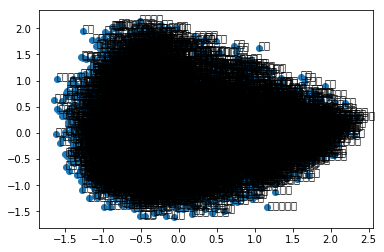

In [52]:
#x=new_model[new_model.wv.vocab]
#pca = PCA(n_components=2)
#result = pca.fit_transform(x)
#pyplot.scatter(result[:, 0], result[:, 1])
#words = list(new_model.wv.vocab)
#for i, word in enumerate(words):
    #pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
#pyplot.show()
#단어가 넘 많음 추후에 몇개 단어만 추려서

In [ ]:
# Doc to vec tsne 2차원
# 시간 오래걸림 내노트북에서 2시간30분

In [15]:
model_loaded.docvecs
tsne_model = TSNE(n_components=2, random_state=0, verbose = 1, init= "pca", method = "exact")
tsne_2D = tsne_model.fit_transform(model_loaded.docvecs)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 7174
[t-SNE] Computed conditional probabilities for sample 2000 / 7174
[t-SNE] Computed conditional probabilities for sample 3000 / 7174
[t-SNE] Computed conditional probabilities for sample 4000 / 7174
[t-SNE] Computed conditional probabilities for sample 5000 / 7174
[t-SNE] Computed conditional probabilities for sample 6000 / 7174
[t-SNE] Computed conditional probabilities for sample 7000 / 7174
[t-SNE] Computed conditional probabilities for sample 7174 / 7174
[t-SNE] Mean sigma: 2.530940
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.494444
[t-SNE] Error after 1000 iterations: 3.167057


In [53]:
len(model_loaded.docvecs)

7174

array([ 20.65333176,  59.69342041], dtype=float32)

In [ ]:
#우리 근데 왜 문서가 7174개이지?

In [25]:
#전체 문서 7174개의 모든 콤비네이션으로 유사도를 계산해서
# 분포로 나타냄 mean0.2
cosine_similarities = []
for r in range(len(model_loaded.docvecs)):
    for t in range(r+1,7174):
        cosine_similarities.append(model_loaded.docvecs.similarity(r,t))

In [26]:
len(cosine_similarities)

25729551

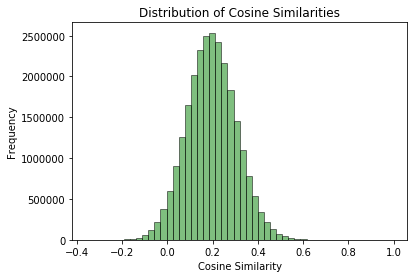

In [27]:
plt.hist(cosine_similarities, 50, facecolor='green', alpha=0.5,ec="black")
plt.title('Distribution of Cosine Similarities')
plt.ylabel('Frequency')
plt.xlabel('Cosine Similarity')
plt.show()

In [12]:
def string_to_digit(string):
    digit = []
    for r in string:
        if r.isdigit():
            digit.append(r)
    return int(''.join(digit))

In [13]:
#문서당 가장 높은 유사도를 가진 문서 뽑기
top_scores = []
for vec in range(len(model_loaded.docvecs)):
    top = model_loaded.docvecs.most_similar(vec, topn = 1)
    top_scores.append((vec, string_to_digit(top[0][0]), top[0][1]))

In [14]:
top_sorted = sorted(top_scores, key = itemgetter(2), reverse = True)
first = top_sorted[:5000]
first_doc = []
for k,v,w in first:
    first_doc.append(k)

In [146]:
first[0][1]

142064

In [148]:
len(first_doc)

5000

In [1]:
kmeans = KMeans(3, n_jobs=-1)
top_cluster_results = kmeans.fit_predict(model.loaded_docvecs)

NameError: name 'KMeans' is not defined

In [166]:
len(top_cluster_results)

5000

In [151]:
import PyQt5
%matplotlib qt

In [167]:
plt.scatter([x[0] for x in tsne_2D[first_doc]], [x[1] for x in tsne_2D[first_doc]], c=top_cluster_results)
plt.show()

In [153]:
tsne_idx = tsne_2D[first_doc]
tsne_idx[0]

array([-52.44774628,  45.03383255], dtype=float32)

In [154]:
plt.scatter([x[0] for x in tsne_2D[first_doc]], [x[1] for x in tsne_2D[first_doc]], c=top_cluster_results)
for i, idx in enumerate(first_doc):
    plt.annotate(idx, xy=(tsne_idx[i,0], tsne_idx[i,1]))
plt.rcParams.update({'font.size': 10})
plt.show()

In [161]:
cluster_0 = []
cluster_1 = []
cluster_2 = []
cluster_3 = []
cluster_4 = []
for i, clusters in enumerate(top_cluster_results):
    if clusters == 0:
        cluster_0.append(first[i][1])
    if clusters == 1:
        cluster_1.append(first[i][1])
    if clusters == 2:
        cluster_2.append(first[i][1])
    if clusters == 3:
        cluster_3.append(first[i][1])
    if clusters == 4:
        cluster_4.append(first[i][1])    

In [162]:
for i in cluster_0:
    print(labeled_data.loc[i,"사건명"])

강도상해
강도상해
강도상해,폭력행위등처벌에관한법률위반
존속협박ㆍ특수협박
위계공무집행방해
위계공무집행방해
사기
사기
국가공무원법위반
국가공무원법위반
특수절도
강도상해,특수절도
강도상해,폭력행위등처벌에관한법률위반
국가공무원법위반
특수절도
사기,위증
위증
특수절도ㆍ특수절도미수ㆍ폭력행위등처벌에관한법률위반
특수절도·강도강간(예비:폭력행위등처벌에관한법률위반)·특수강도
사기
국가공무원법위반
공직선거및선거부정방지법위반·모욕
사기
국가공무원법위반
강도강간,강도상해
강도상해,특수절도
강도상해
특수공무집행방해,근로기준법위반,사문서위조,사문서위조행사
사기
미성년자의제추행치상
무고
무고
사기
업무상횡령
강도상해,특수절도
국가공무원법위반
특정범죄가중처벌등에관한법률위반,뇌물공여의사표시,보호감호
국가공무원법위반,방실퇴거불응
강도상해,특수절도
국가공무원법위반,방실퇴거불응
사기
위증
강도상해
국가공무원법위반
보호감호ㆍ상습사기
강도상해
존속협박ㆍ특수협박
보호감호·특정범죄가중처벌등에관한법률위반·주거침입(변경:폭력행위등처벌에관한법률위반)
보호감호,특정범죄가중처벌등에관한법률위반,절도
위계 공무 집행 방해
업무방해
특정범죄가중처벌등에관한법률위반·보호감호
강간치상(예비적:강간)
반공법위반ㆍ신용훼손
강도상해ㆍ야간주거침입절도ㆍ공문서변조ㆍ공문서변조행사ㆍ사문서변조ㆍ사문서변조행사
강도상해
강도상해
강도강간,강도상해
위증
위증
절도
보호감호,상습사기
사기
무고
위증
위증
업무방해
증거위조
위증교사(변경된 죄명 : 증거위조)
특정범죄가중처벌등에관한법률위반,뇌물공여의사표시,보호감호
보호감호·특정범죄가중처벌등에관한법률위반·장물알선
무고ㆍ명예훼손ㆍ재물손괴
명예훼손
강도미수
보호감호·특정범죄가중처벌등에관한법률위반·장물알선
국가공무원법위반,방실퇴거불응
무고
위증
명예훼손
공갈,공갈미수,변호사법위반,명예훼손
강도상해,특수절도
강도상해
사기·상해
국가공무원법위반,방실퇴거불응
사기
특정경제범죄가중처벌등에관한법률위반,공문서위조,공문서위조행사,상호신용금고법위반
간통
위증
위증교사
위증
폭력행위등처벌에관한법률위반,특수절도(공소취소),

In [163]:
for i in cluster_3:
    print(labeled_data.loc[i,"사건명"])

배임ㆍ상호신용금고법 위반
배임ㆍ상호신용금고법위반
정치자금법위반·국가공무원법위반·정당법위반
정치자금법위반·국가공무원법위반·정당법위반·지방공무원법위반
업무상횡령·허위공문서작성·허위작성공문서행사
업무상횡령·허위공문서작성·허위작성공문서행사
정치자금법위반·국가공무원법위반·정당법위반
허위 공문서 작성·동행사
허위공문서작성,허위공문서작성행사
화물자동차운수사업법 위반·위계공무집행방해
화물 자동차 운수 사업법 위반·위계 공무 집행 방해·위조 사문서 행사
정치자금법위반·국가공무원법위반·정당법위반
집단 에너지 사업법 위반·업무 방해·노동조합 및 노동관계 조정법 위반
집단 에너지 사업법 위반·업무 방해·노동조합 및 노동관계 조정법 위반
사기·사문서위조·위조사문서행사
도로교통법위반(음주운전)·도로교통법위반(무면허운전)·자동차손해배상보장법위반·상해
사기
횡령
특정경제범죄가중처벌등에관한법률위반(배임)·특정범죄가중처벌등에관한법률위반(조세)·증권거래법위반
특정경제범죄가중처벌등에관한법률위반(배임)(에버랜드 전환사채 발행 사건)
뇌물공여의사표시,특정범죄가중처벌등에관한법률위반,조세범처벌법위반
뇌물공여의사표시ㆍ특정범죄가중처벌등에관한법률위반ㆍ조세범처벌법위반
특정경제범죄가중처벌등에관한법률위반(배임)
특정경제범죄가중처벌등에관한법률위반(배임)
특정경제범죄가중처벌등에관한법률위반(사기)·사기·사문서위조·위조사문서행사·업무상배임·공전자기록등불실기재·불실기재공전자기록등행사
사기·자동차손해배상보장법위반
횡령
부당이득
부당이득
특정경제범죄가중처벌 등에 관한 법률 위반(사기)·특정경제범죄가중처벌 등에 관한 법률 위반(배임)·증권거래법 위반
특정경제범죄가중처벌등에관한법률위반(횡령)[피고인1에대한일부예비적죄명:특정경제범죄가중처벌등에관한법률위반(배임)]·특정경제범죄가중처벌등에관한법률위반(사기)·특정경제범죄가중처벌등에관한법률위반(배임)[피고인1에대하여일부인정된죄명:업무상배임)]·증권거래법위반·주식회사의외부감사에관한법률위반·사기·업무상배임·업무상횡령·노동조합및노동관계조정법위반·근로기준법위반
배임수재
배임수재·배임증재
뇌물수수